# XGBoost Using Linear Regression

In [70]:
import math
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import time
#import pandas_datareader.data as web

from datetime import date, datetime, time, timedelta
from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from tqdm import tqdm_notebook
import helper_functions

%matplotlib inline


test_size = 0.2                 # proportion of dataset to be used as test set
cv_size = 0.2                   # proportion of dataset to be used as cross-validation set
Nmax = 30                       # for feature at day t, we use lags from t-1, t-2, ..., t-N as features
                                # Nmax is the maximum N we are going to test

In [71]:
def get_preds_lin_reg(df, target_col, N, pred_min, offset):

    
    regr = LinearRegression(fit_intercept=True)

    pred_list = []

    for i in range(offset, len(df['adj_close'])):
        X_train = np.array(range(len(df['adj_close'][i-N:i]))) 
        y_train = np.array(df['adj_close'][i-N:i]) 
        X_train = X_train.reshape(-1, 1)     
              
        y_train = y_train.reshape(-1, 1)
    #     print X_train.shape
    #     print y_train.shape
    #     print 'X_train = \n' + str(X_train)
    #     print 'y_train = \n' + str(y_train)
        regr.fit(X_train, y_train)            
        pred = regr.predict(np.array(N).reshape(1,-1))
    
        pred_list.append(pred[0][0])  
    
    # If the values are < pred_min, set it to be pred_min
    pred_list = np.array(pred_list)
    pred_list[pred_list < pred_min] = pred_min
        
    return pred_list




def get_mape(y_true, y_pred): 

    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [72]:
number_of_days=1000

#Treatment pools
#treatment_pool_id="0x4a5a2a152e985078e1a4aa9c3362c412b7dd0a86"  #wstETH/WETH 0.05%
#treatment_pool_id="0x1c3140ab59d6caf9fa7459c6f83d4b52ba881d36" #OP/USDC 0.3%
#treatment_pool_id="0xbf16ef186e715668aa29cef57e2fd7f9d48adfe6" #USDC/DAI 0.01%
#treatment_pool_id="0x03af20bdaaffb4cc0a521796a223f7d85e2aac31" #WETH/DAI 0.3%
treatment_pool_id="0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640" #USDC/ETH 0.05%
#treatment_url="https://api.thegraph.com/subgraphs/name/ianlapham/optimism-post-regenesis"
treatment_url="https://api.thegraph.com/subgraphs/name/uniswap/uniswap-v3"


#Control pools
#control_pool_id="0xd340b57aacdd10f96fc1cf10e15921936f41e29c" #wstETH/ETH 0.05% on ETH
#control_pool_id="0x68f5c0a2de713a54991e01858fd27a3832401849" #WETH/OP 0.3%
control_pool_id="0xf1f199342687a7d78bcc16fce79fa2665ef870e1" #USDC/USDT 0.01% 
#control_pool_id="0x85149247691df622eaf1a8bd0cafd40bc45154a9"  #WETH/USDC 0.05%
control_url="https://api.thegraph.com/subgraphs/name/ianlapham/optimism-post-regenesis"
#control_url="https://api.thegraph.com/subgraphs/name/uniswap/uniswap-v3"

# Define Incentive and sample periods

start_date = pd.to_datetime('2022-12-15')
end_date = pd.to_datetime('2023-05-15')


uniswap_data = helper_functions.get_uniswap_data(treatment_pool_id,number_of_days,treatment_url)
treatment_df = pd.DataFrame(uniswap_data)
treatment_df=helper_functions.preprocess_data(treatment_df)


df = treatment_df.loc[(treatment_df['date'] >= start_date) & (treatment_df['date'] < end_date)].reset_index(drop=True)

#df['date']=df.index


df.head(10)

,date,tick,sqrtPrice,liquidity,volumeUSD,volumeToken0,volumeToken1,tvlUSD,feesUSD,close,open,low,high,adj_close
0,2023-05-14,201365,23571.317215,2.011560e+19,1.089402e+08,1.089385e+08,60336.455038,4.280887e+08,54470.117220,1795.988088,1795.988088,1793.472105,1822.919512,1795.988088
1,2023-05-13,201386,23596.12032,1.961545e+19,1.342162e+08,1.342218e+08,74450.539729,4.278633e+08,67108.100251,1808.231800,1808.231800,1789.702934,1818.123145,1808.231800
2,2023-05-12,201319,23516.514254,2.594937e+19,3.265968e+08,3.264671e+08,184899.406807,4.255742e+08,163298.409465,1796.070644,1796.070644,1659.922320,1814.081692,1796.070644
3,2023-05-11,201386,23595.960931,1.767920e+19,3.729817e+08,3.729305e+08,206120.979285,4.240384e+08,186490.859376,1842.155469,1842.155469,1776.583356,1842.331091,1842.155469
4,2023-05-10,201133,23299.000403,2.812333e+19,3.309939e+08,3.310024e+08,179198.477386,4.309947e+08,165496.948976,1848.657376,1848.657376,1795.409619,1887.506744,1848.657376
5,2023-05-09,201098,23257.977372,2.212661e+19,1.723356e+08,1.722839e+08,93358.946533,4.630431e+08,86167.780069,1847.588706,1847.588706,1832.561862,1859.931624,1847.588706
6,2023-05-08,201106,23267.546415,2.050424e+19,3.424419e+08,3.424393e+08,184578.605084,4.648268e+08,171220.941747,1871.332666,1871.332666,1814.343241,1884.986345,1871.332666
7,2023-05-07,200964,23102.98419,2.947254e+19,2.035346e+08,2.034906e+08,106634.682775,4.688951e+08,101767.288351,1900.253278,1900.253278,1873.477851,1933.085142,1900.253278
8,2023-05-06,200822,22940.056473,3.057995e+19,4.181099e+08,4.179528e+08,217950.552112,4.706677e+08,209054.968446,1995.601313,1995.601313,1857.722620,2023.126194,1995.601313
9,2023-05-05,200333,22385.306316,1.415638e+19,3.284713e+08,3.285632e+08,169142.158726,4.714919e+08,164235.654384,1876.474504,1876.474504,1875.906111,2008.923028,1876.474504


Text(0, 0.5, 'USD')

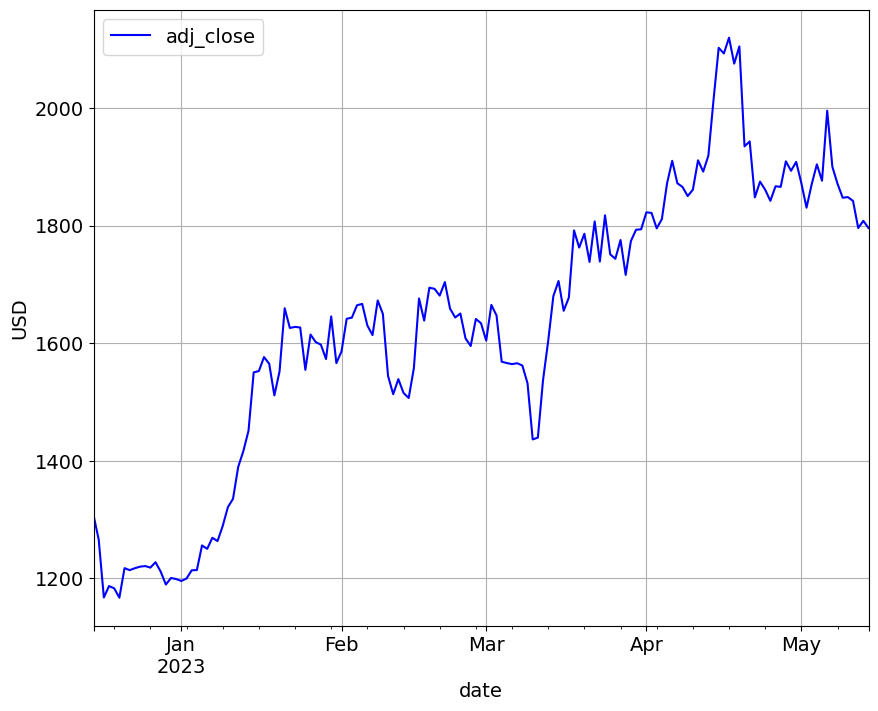

In [73]:
#Get month of each sample
df['month'] = df['date'].dt.month

# Sort by datetime
df.sort_values(by='date', inplace=True, ascending=True)
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = df.plot(x='date', y='adj_close', style='b-', grid=True)
ax.set_xlabel("date")
ax.set_ylabel("USD")

In [74]:
num_cv = int(cv_size*len(df))
num_test = int(test_size*len(df))
num_train = len(df) - num_cv - num_test
print("num_train = " + str(num_train))
print("num_cv = " + str(num_cv))
print("num_test = " + str(num_test))

# Split into train, cv, and test
train = df[:num_train].copy()
cv = df[num_train:num_train+num_cv].copy()
train_cv = df[:num_train+num_cv].copy()
test = df[num_train+num_cv:].copy()
print("train.shape = " + str(train.shape))
print("cv.shape = " + str(cv.shape))
print("train_cv.shape = " + str(train_cv.shape))
print("test.shape = " + str(test.shape))

num_train = 91
num_cv = 30
num_test = 30
train.shape = (91, 15)
cv.shape = (30, 15)
train_cv.shape = (121, 15)
test.shape = (30, 15)


Text(0, 0.5, 'USD')

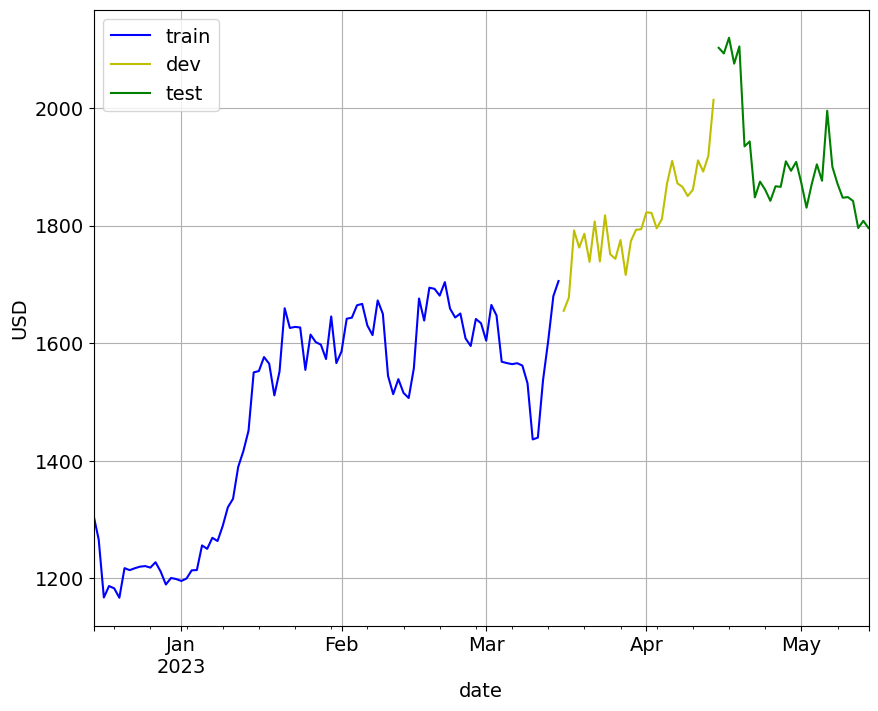

In [75]:
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

In [76]:
RMSE = []
R2 = []
mape = []
for N in range(1, Nmax+1): # N is no. of samples to use to predict the next value
    est_list = get_preds_lin_reg(train_cv, 'adj_close', N, 0, num_train)
    
    cv.loc[:, 'est' + '_N' + str(N)] = est_list
    RMSE.append(math.sqrt(mean_squared_error(est_list, cv['adj_close'])))
    R2.append(r2_score(cv['adj_close'], est_list))
    mape.append(get_mape(cv['adj_close'], est_list))
print('RMSE = ' + str(RMSE))
print('R2 = ' + str(R2))
print('MAPE = ' + str(mape))
cv.head()

RMSE = [48.11572649787814, 77.25402368292445, 59.68542136133049, 55.98472698417586, 55.03335923894603, 52.46371486526242, 47.29737645059093, 44.24043731544802, 45.5668061595276, 47.552265972007405, 50.26210219523657, 53.93557790690075, 57.25433945215208, 60.348343205660974, 64.44387080151513, 67.55600355711987, 70.18435188271472, 72.49734559792269, 73.49010071835916, 73.91968579065534, 74.54632288375811, 75.4602183112652, 76.75770147649615, 77.92258042846251, 78.91445511652407, 79.58298590800419, 80.67981128525676, 81.77256052017772, 82.53768589803826, 83.1159772331819]
R2 = [0.5927507143694521, -0.04985290139790344, 0.3733532892402689, 0.4486525562812136, 0.4672318155704811, 0.5158228229509983, 0.6064858631376762, 0.6557094847521413, 0.6347557272087199, 0.602233073355319, 0.5556066681283818, 0.48827467684966097, 0.4233622729416371, 0.35935574035639073, 0.26945079478916034, 0.19718748178967005, 0.13350347858097888, 0.0754499053167248, 0.049955558852705195, 0.0388161605018319, 0.0224506

,date,tick,sqrtPrice,liquidity,volumeUSD,volumeToken0,volumeToken1,tvlUSD,feesUSD,close,...,est_N21,est_N22,est_N23,est_N24,est_N25,est_N26,est_N27,est_N28,est_N29,est_N30
59,2023-03-16,202068,24413.869401,2.974780e+19,4.336807e+08,4.336931e+08,261150.974941,3.759267e+08,216840.328278,1655.246316,...,1556.983822,1554.256766,1548.492261,1546.146001,1543.692620,1541.916521,1544.978720,1545.176189,1553.854605,1564.779545
58,2023-03-17,201404,23617.471548,2.175010e+19,7.988000e+08,7.992191e+08,460884.810879,3.631519e+08,399399.984904,1677.758048,...,1574.409889,1571.575804,1568.190536,1561.934411,1558.970308,1555.939901,1553.593950,1555.947155,1555.594625,1563.477691
57,2023-03-18,201573,23817.605736,3.379439e+19,6.964113e+08,6.963892e+08,385911.149777,3.588683e+08,348205.652600,1791.978706,...,1596.701763,1591.461368,1587.933522,1583.919871,1577.183541,1573.620681,1570.025658,1567.118950,1568.779365,1567.878536
56,2023-03-19,201448,23668.636821,2.039716e+19,4.980790e+08,4.981351e+08,276882.842090,3.613553e+08,249039.497765,1762.803062,...,1635.726697,1632.376568,1625.820326,1620.986449,1615.773042,1608.015440,1603.360633,1598.738671,1594.838830,1595.410059
55,2023-03-20,201712,23983.845761,2.647930e+19,7.048849e+08,7.048117e+08,398453.170768,3.583840e+08,352442.463178,1786.267985,...,1665.153334,1661.753907,1657.544880,1650.316695,1644.762955,1638.877346,1630.569284,1625.261739,1620.013724,1615.489558


Text(0, 0.5, 'RMSE')

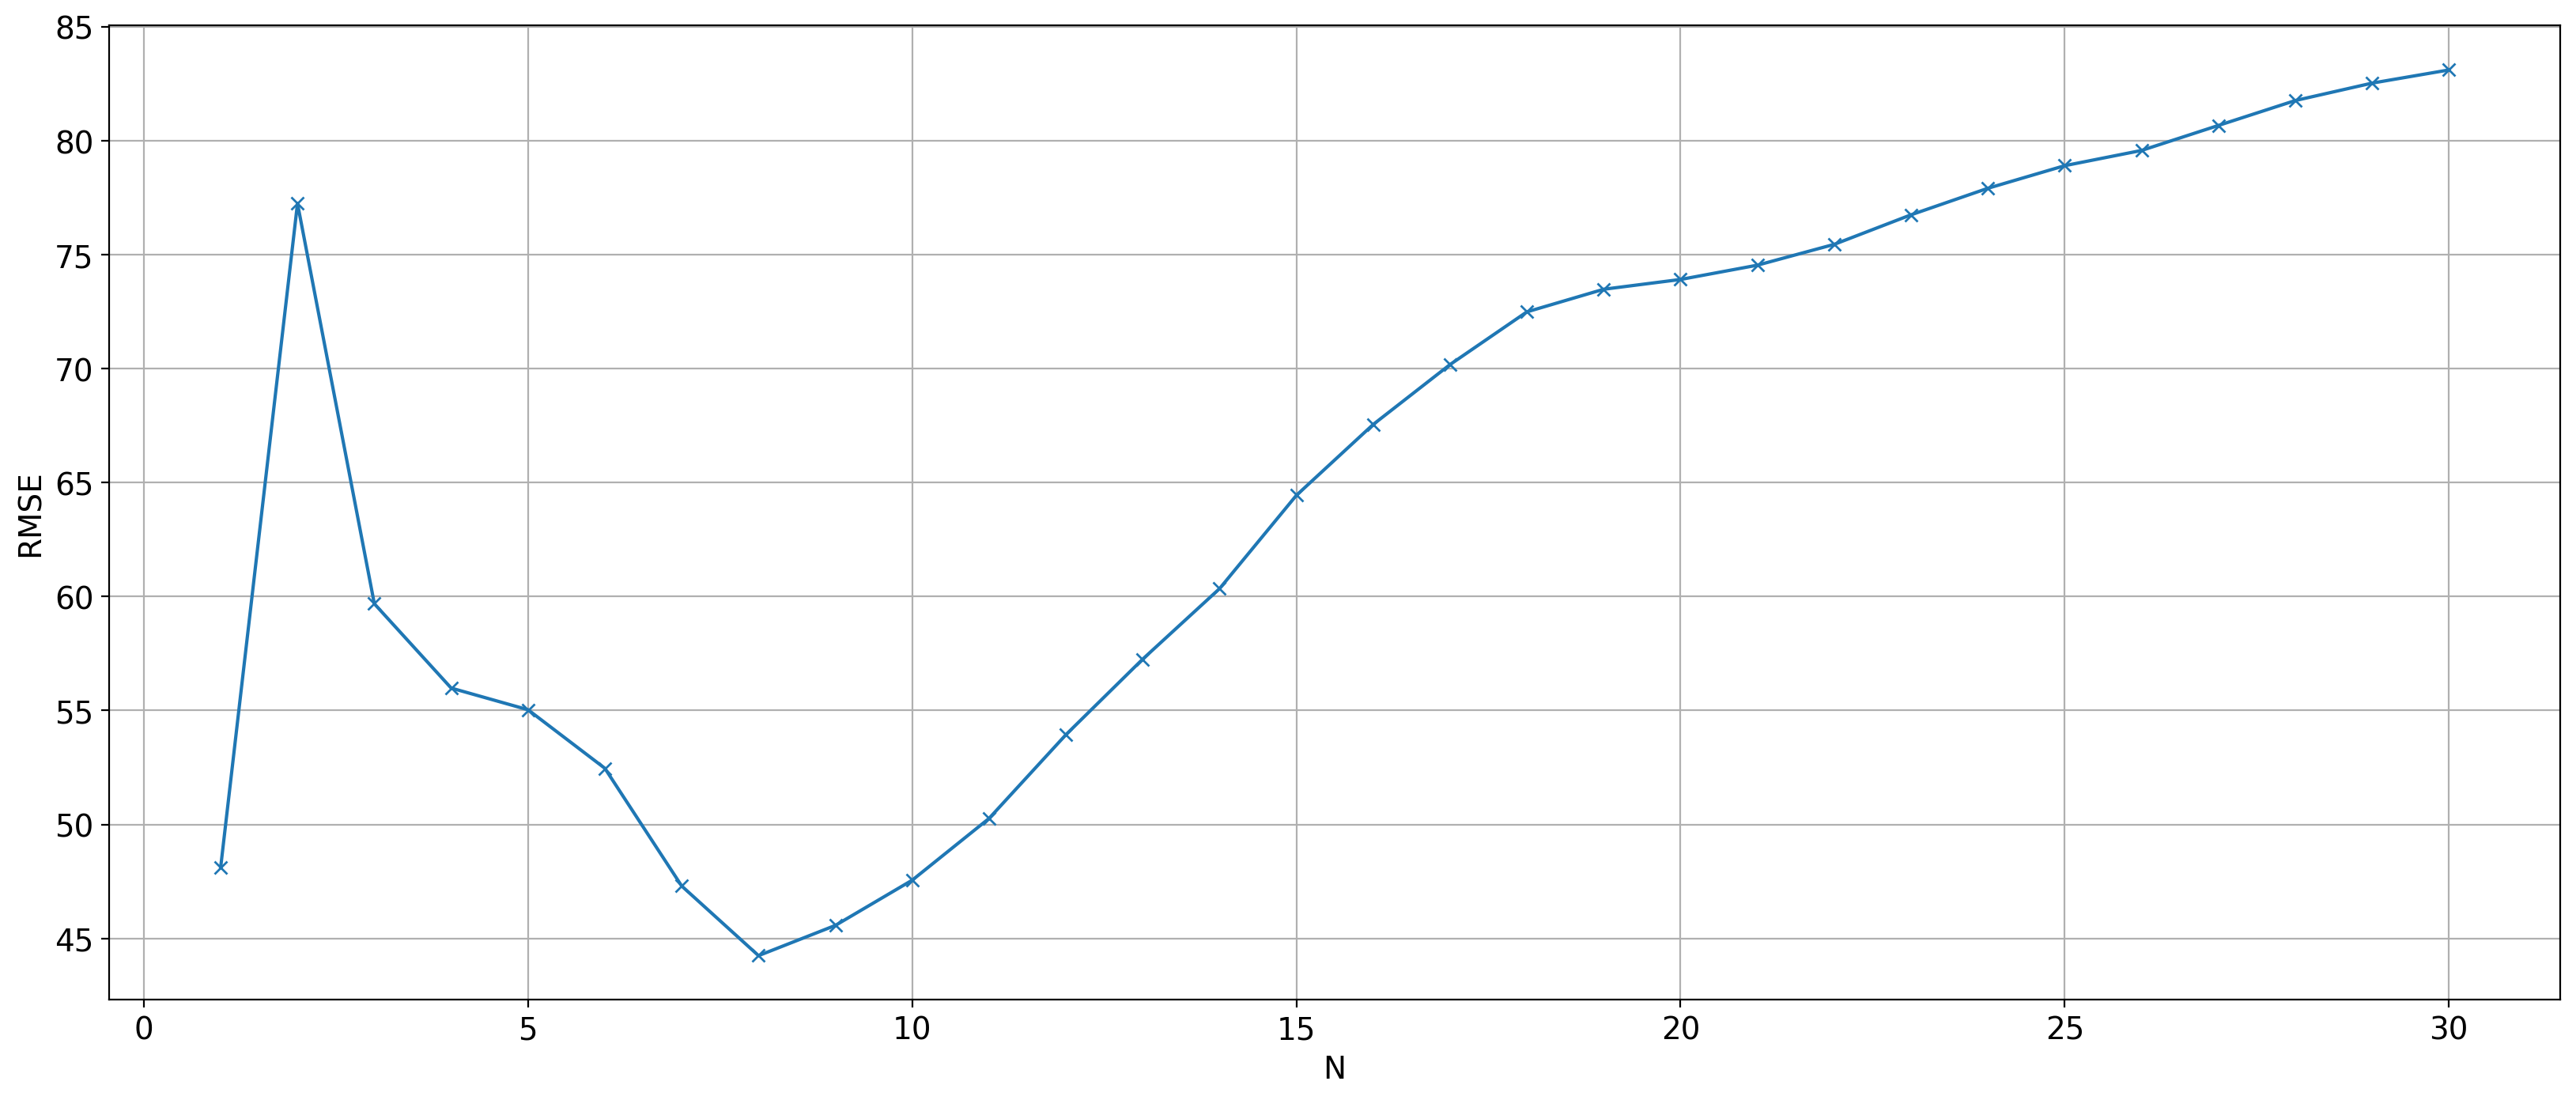

In [77]:
matplotlib.rcParams.update({'font.size': 14})
plt.figure(figsize=(20, 8), dpi=200)
plt.plot(range(1, Nmax+1), RMSE, 'x-')
plt.grid()
plt.xlabel('N')
plt.ylabel('RMSE')
#plt.xlim([2, 30])

Text(0, 0.5, 'R2')

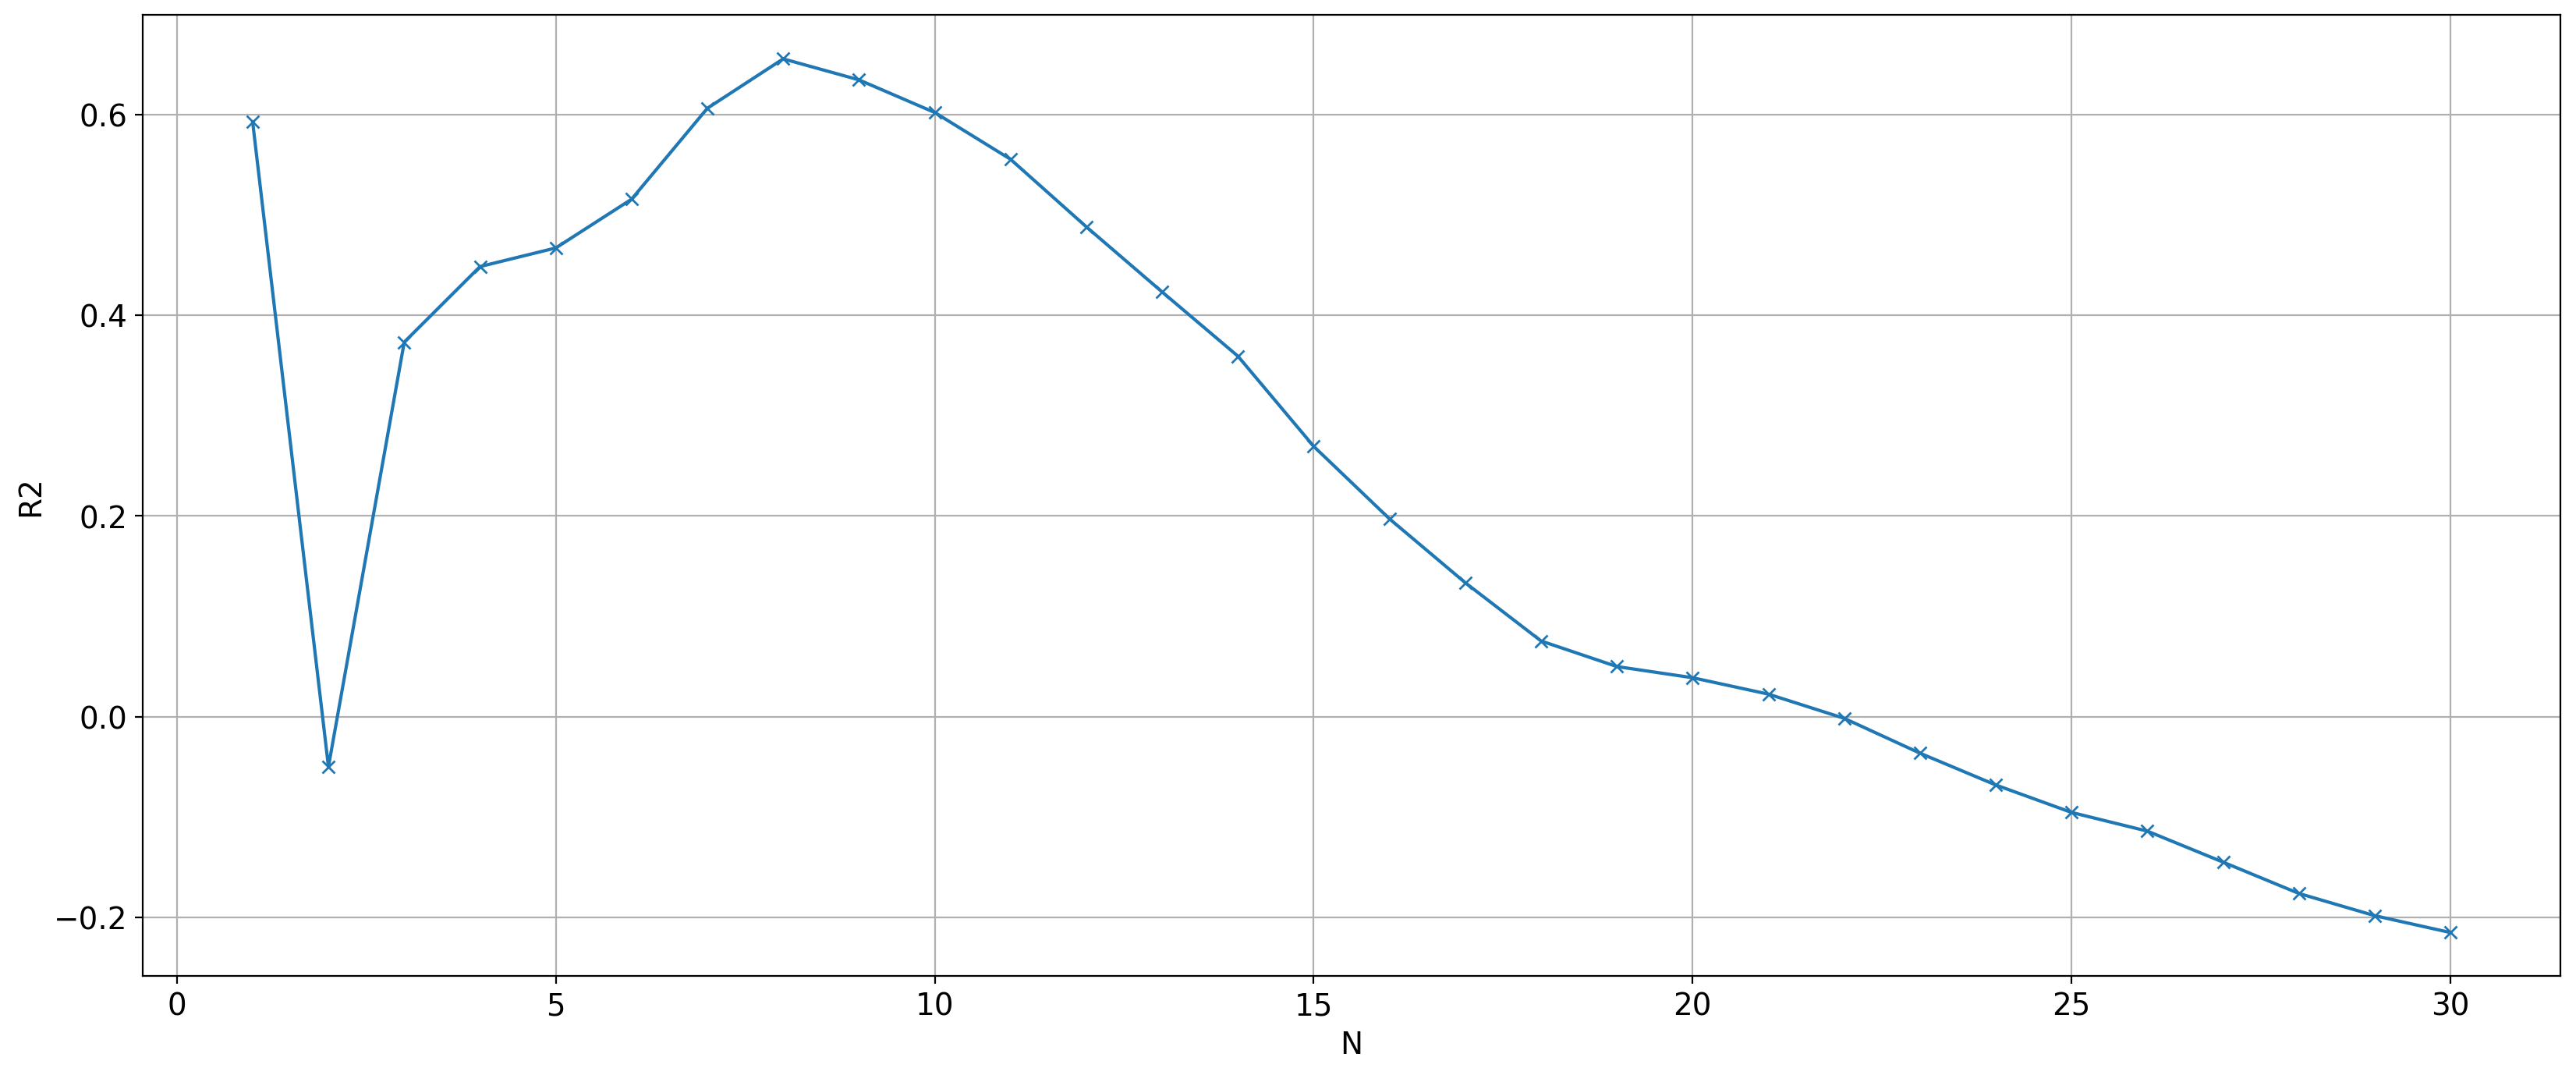

In [78]:
# Plot R2 versus N. Note for R2 larger better. 
matplotlib.rcParams.update({'font.size': 14})
plt.figure(figsize=(20, 8), dpi=200)
plt.plot(range(1, Nmax+1), R2, 'x-')
plt.grid()
plt.xlabel('N')
plt.ylabel('R2')

Text(0, 0.5, 'MAPE')

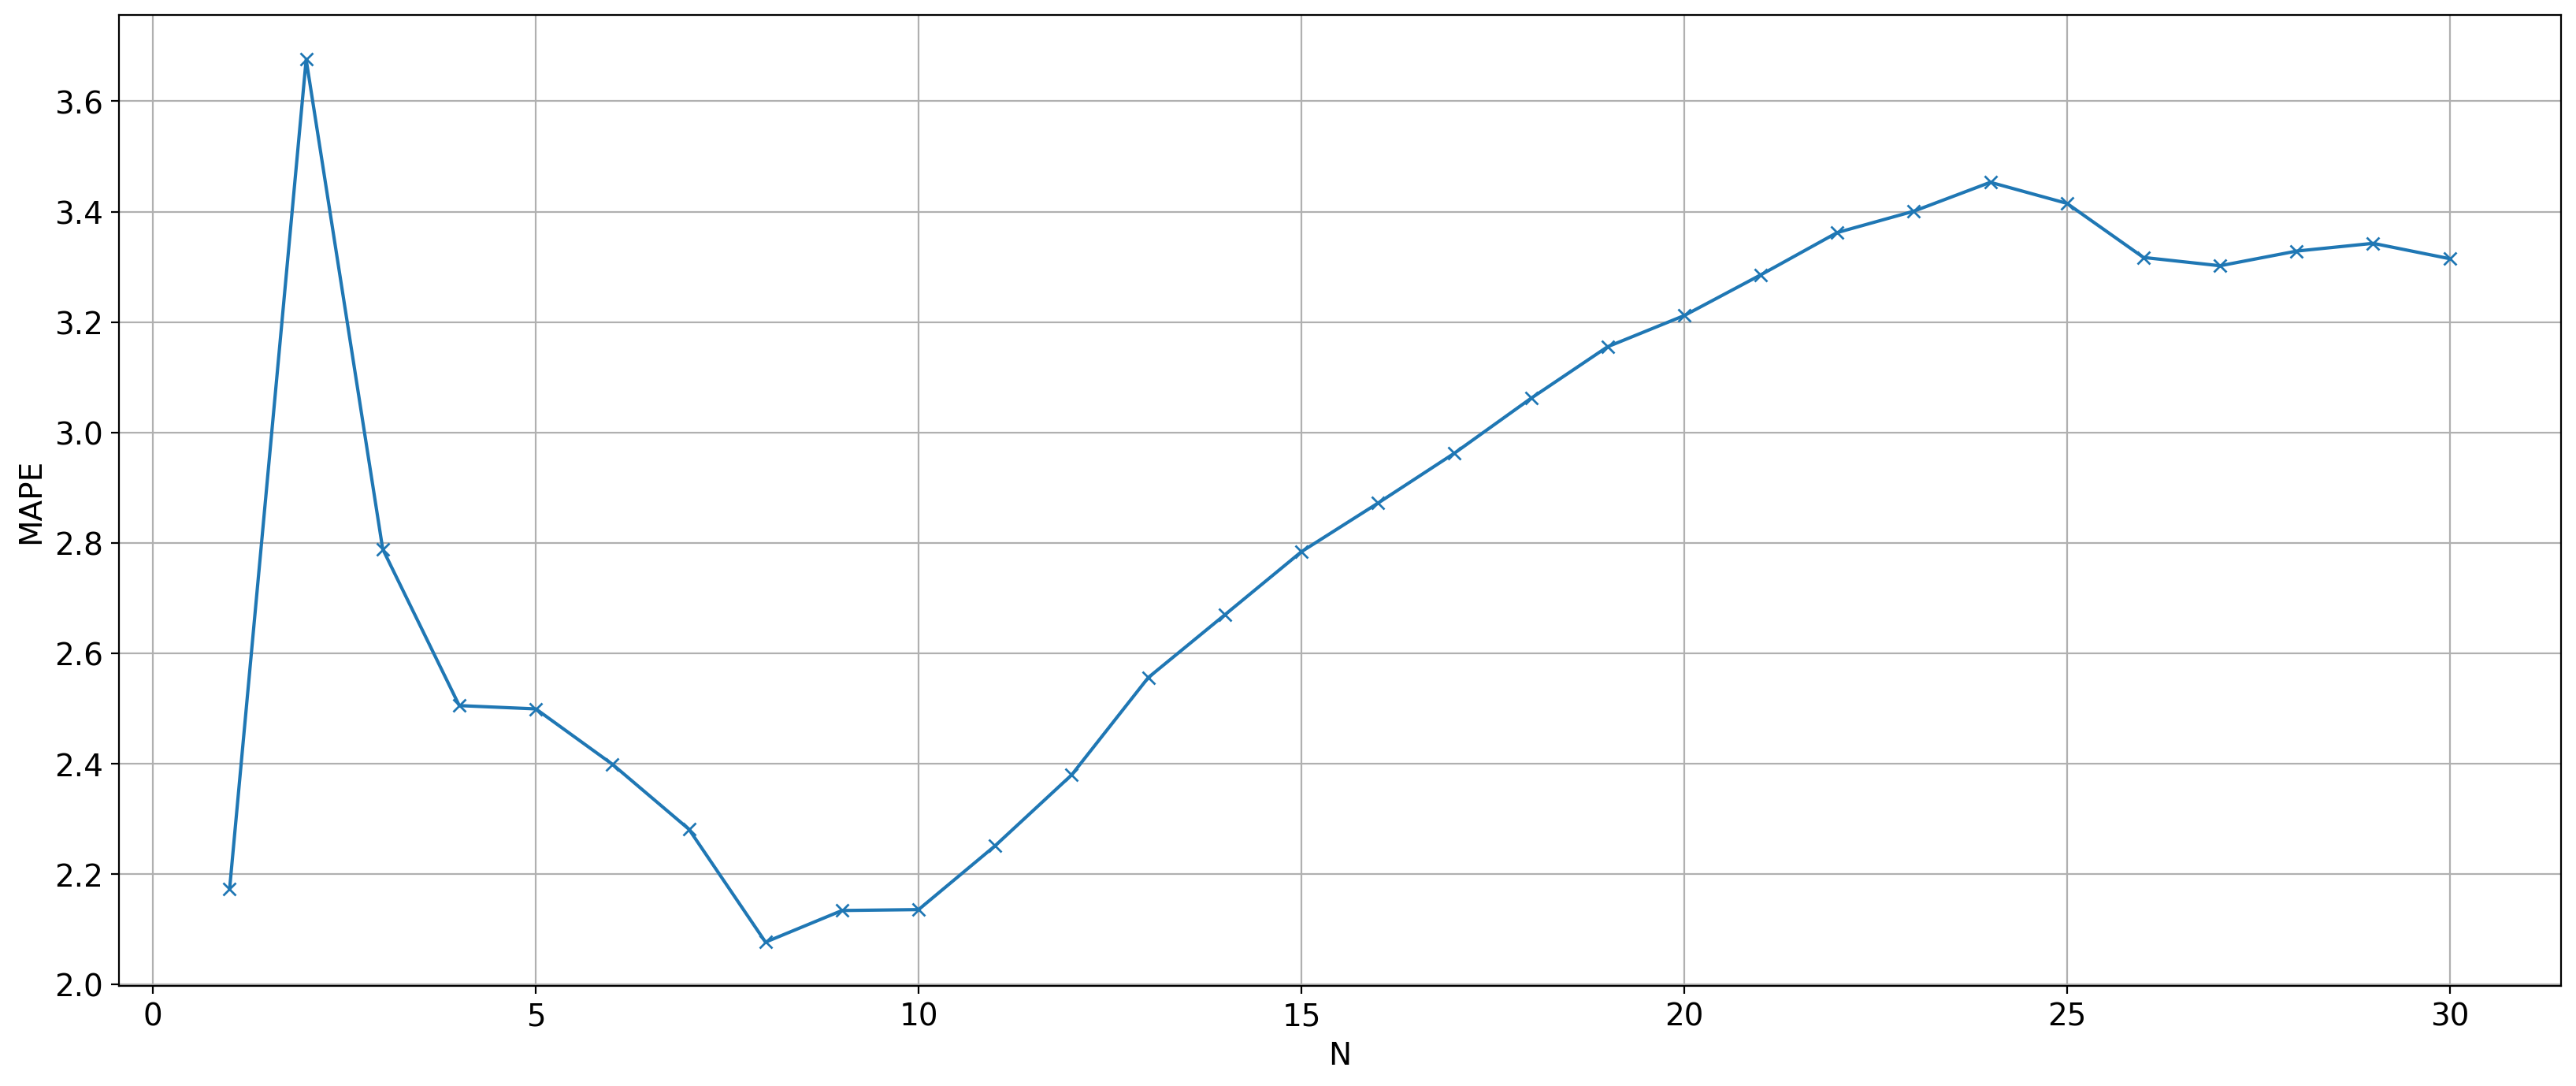

In [79]:
# Plot MAPE versus N. Note for MAPE smaller better. 
plt.figure(figsize=(20, 8), dpi=200)
plt.plot(range(1, Nmax+1), mape, 'x-')
plt.grid()
plt.xlabel('N')
plt.ylabel('MAPE')

ValueError: x and y must have same first dimension, but have shapes (6,) and (0,)

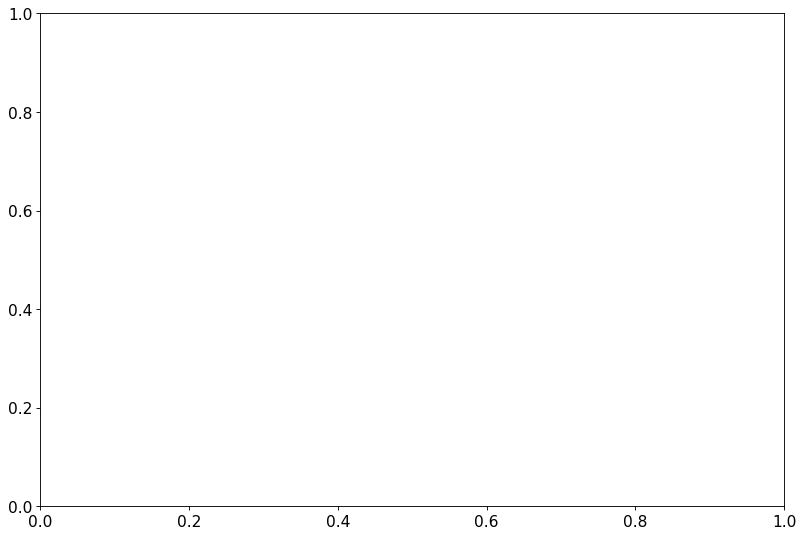

In [80]:

# Specify the day you are interested in.Here lets check for date 2nd February 2018
day = pd.Timestamp(date(2023,2,2))

# Specify the maximum N you want to plot (If Nmax2 is too large it gets very cluttered) 
Nmax2 = 5

df_temp = cv[cv['date'] <= day].reset_index(drop=True)
plt.figure(figsize=(12, 8), dpi=80)
plt.plot(range(1,Nmax2+2), df_temp[-Nmax2-2:]['adj_close'], 'bx-')
plt.plot(Nmax2+1, df_temp[-1:]['adj_close'], 'ys-')
legend_list = ['adj_close', 'actual_value']

# Plot the linear regression lines and the predictions
color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
marker_list = ['x', 'x', 'x', 'x', 'x', 'x', 'x']
regr = LinearRegression(fit_intercept=True) # Create linear regression object
for N in range(5, Nmax2+1):
    # Plot the linear regression lines
    X_train = np.array(range(len(df_temp['adj_close'][-N-1:-1]))) # e.g. [0 1 2 3 4]
    y_train = np.array(df_temp['adj_close'][-N-1:-1]) # e.g. [2944 3088 3226 3335 3436]
    X_train = X_train.reshape(-1, 1)     
    y_train = y_train.reshape(-1, 1)
    regr.fit(X_train, y_train)            # Train the model
    y_est = regr.predict(X_train)         # Get linear regression line
    plt.plot(range(Nmax2+1-N,Nmax2+2), 
             np.concatenate((y_est, np.array(df_temp['est_N'+str(N)][-1:]).reshape(-1,1))),
             color=color_list[N%len(color_list)], 
             marker=marker_list[N%len(marker_list)])
    legend_list.append('est_N'+str(N)+'_lr')
    
    # Plot the predictions
    plt.plot(Nmax2+1, 
             df_temp['est_N'+str(N)][-1:], 
             color=color_list[N%len(color_list)], 
             marker='o')
    legend_list.append('est_N'+str(N))

plt.grid()
plt.xlabel('timestep')
plt.ylabel('USD')
plt.legend(legend_list, bbox_to_anchor=(1.05, 1))
matplotlib.rcParams.update({'font.size': fontsize})

# XGBoost

In [92]:
! pip install xgboost

You should consider upgrading via the 'c:\users\hijaz tr\desktop\cadcadproject1\abcde\scripts\python.exe -m pip install --upgrade pip' command.


In [93]:
import pandas as pd
import numpy as np
import math
import datetime as dt

import matplotlib.pyplot as plt
from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import seaborn as sns

from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler

from plotly.offline import plot, iplot, init_notebook_mode
init_notebook_mode(connected=True)

In [87]:
number_of_days=1000

#Treatment pools
#treatment_pool_id="0x4a5a2a152e985078e1a4aa9c3362c412b7dd0a86"  #wstETH/WETH 0.05%
#treatment_pool_id="0x1c3140ab59d6caf9fa7459c6f83d4b52ba881d36" #OP/USDC 0.3%
#treatment_pool_id="0xbf16ef186e715668aa29cef57e2fd7f9d48adfe6" #USDC/DAI 0.01%
#treatment_pool_id="0x03af20bdaaffb4cc0a521796a223f7d85e2aac31" #WETH/DAI 0.3%
treatment_pool_id="0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640" #USDC/ETH 0.05%
#treatment_url="https://api.thegraph.com/subgraphs/name/ianlapham/optimism-post-regenesis"
treatment_url="https://api.thegraph.com/subgraphs/name/uniswap/uniswap-v3"
#Control pools
#control_pool_id="0xd340b57aacdd10f96fc1cf10e15921936f41e29c" #wstETH/ETH 0.05% on ETH
#control_pool_id="0x68f5c0a2de713a54991e01858fd27a3832401849" #WETH/OP 0.3%
#control_pool_id="0xf1f199342687a7d78bcc16fce79fa2665ef870e1" #USDC/USDT 0.01% 
#control_pool_id="0x85149247691df622eaf1a8bd0cafd40bc45154a9"  #WETH/USDC 0.05%"

# Define sample periods

start_date = pd.to_datetime('2022-12-15')
end_date = pd.to_datetime('2023-05-15')


uniswap_data = helper_functions.get_uniswap_data(treatment_pool_id,number_of_days,treatment_url)
data = pd.DataFrame(uniswap_data)
data=helper_functions.preprocess_data(data)


#df = treatment_df.loc[(treatment_df['date'] >= start_date) & (treatment_df['date'] < end_date)].reset_index(drop=True)

#df['date']=df.index
print("Starting date: ",data.iloc[0][0])
print("Ending date: ", data.iloc[-1][0])
print("Duration: ", data.iloc[-1][0]-data.iloc[0][0])

df.head(10)

Starting date:  2023-06-20 00:00:00
Ending date:  2021-05-05 00:00:00
Duration:  -776 days +00:00:00


,date,tick,sqrtPrice,liquidity,volumeUSD,volumeToken0,volumeToken1,tvlUSD,feesUSD,close,open,low,high,adj_close,month
150,2022-12-15,204883,28103.606765,2.778221e+19,2.961000e+08,2.959190e+08,231400.427756,3.191820e+08,148049.991033,1307.502741,1307.502741,1260.615742,1310.708278,1307.502741,12
149,2022-12-16,205696,29269.165855,1.785473e+19,5.336884e+08,5.333930e+08,443237.715218,3.019347e+08,266844.220208,1266.124864,1266.124864,1151.225300,1278.484646,1266.124864,12
148,2022-12-17,205529,29026.299164,1.633227e+19,3.067060e+08,3.068113e+08,260216.681593,3.045927e+08,153353.000454,1167.499396,1167.499396,1151.438134,1222.809708,1167.499396,12
147,2022-12-18,205563,29076.122675,3.960280e+19,1.078744e+08,1.078717e+08,91102.666238,3.077322e+08,53937.204888,1186.949104,1186.949104,1173.390260,1195.596511,1186.949104,12
146,2022-12-19,205697,29271.594094,1.753899e+19,2.202945e+08,2.202655e+08,186912.339090,3.042013e+08,110147.227263,1183.035014,1183.035014,1152.410885,1205.237660,1183.035014,12
145,2022-12-20,205275,28660.220963,2.222731e+19,2.410678e+08,2.412429e+08,199921.954868,3.126094e+08,120533.884544,1167.093919,1167.093919,1164.059357,1234.617705,1167.093919,12
144,2022-12-21,205304,28701.805871,2.311553e+19,1.390450e+08,1.390787e+08,114690.375416,3.151121e+08,69522.511070,1217.409939,1217.409939,1204.903390,1226.204801,1217.409939,12
143,2022-12-22,205276,28661.687968,2.238148e+19,1.617073e+08,1.616772e+08,133997.340098,3.147440e+08,80853.663378,1214.005994,1214.005994,1179.482781,1236.174761,1214.005994,12
142,2022-12-23,205254,28630.528488,2.402169e+19,1.872697e+08,1.875149e+08,153201.335229,3.170100e+08,93634.835215,1217.290710,1217.290710,1213.510741,1247.689535,1217.290710,12
141,2022-12-24,205246,28618.979724,5.290668e+19,4.745210e+07,4.746100e+07,38916.413875,3.190949e+08,23726.049862,1219.953676,1219.953676,1215.146859,1225.544763,1219.953676,12


In [97]:
closedf = data[['date','close']]
print("Shape of close dataframe:", closedf.shape)

close_stock = closedf.copy()
print("Total data for prediction: ",closedf.shape[0])
closedf

Shape of close dataframe: (777, 2)
Total data for prediction:  777


,date,close
0,2023-06-20,1736.365500
1,2023-06-19,1719.454116
2,2023-06-18,1727.476808
3,2023-06-17,1716.534481
4,2023-06-16,1664.949276
...,...,...
772,2021-05-09,3886.561270
773,2021-05-08,3448.215490
774,2021-05-07,3492.800581
775,2021-05-06,3519.716693


In [103]:
#del closedf['date']
scaler=MinMaxScaler(feature_range=(0,1))
closedf=scaler.fit_transform(np.array(closedf).reshape(-1,1))
print(closedf.shape)


(777, 1)


In [104]:
training_size=int(len(closedf)*0.70)
test_size=len(closedf)-training_size
train_data,test_data=closedf[0:training_size,:],closedf[training_size:len(closedf),:1]
print("train_data: ", train_data.shape)
print("test_data: ", test_data.shape)

train_data:  (543, 1)
test_data:  (234, 1)


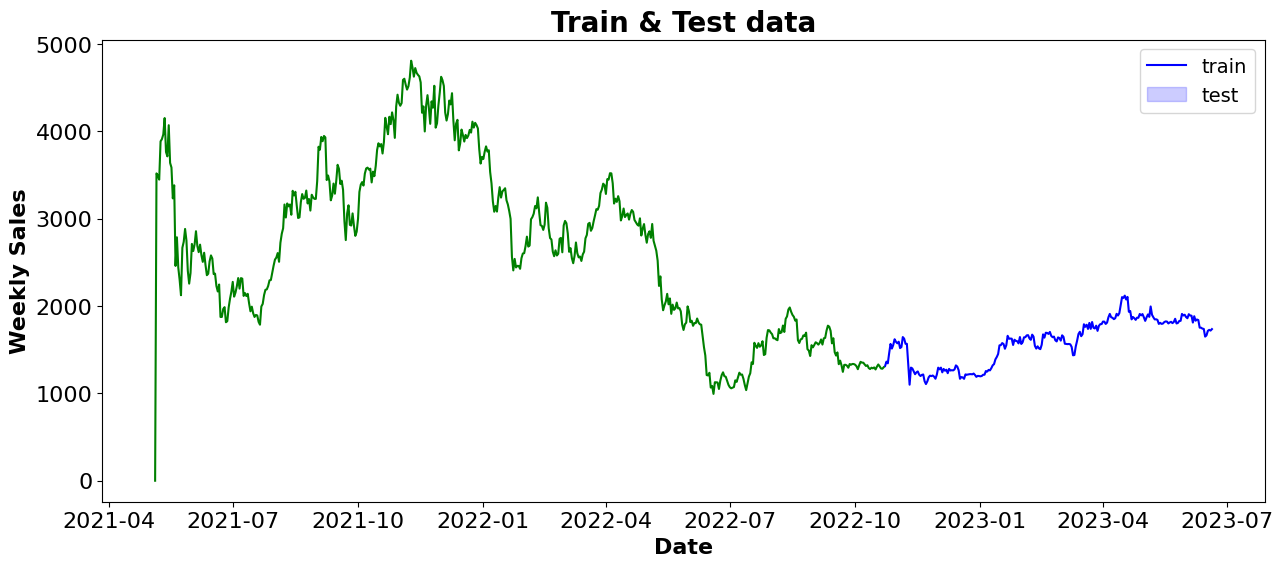

In [106]:
fig, ax = plt.subplots(figsize=(15, 6))
sns.lineplot(x = close_stock['date'][:241], y = close_stock['close'][:241], color = 'blue')
sns.lineplot(x = close_stock['date'][241:], y = close_stock['close'][241:], color = 'green')

# Formatting
ax.set_title('Train & Test data', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Date', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Weekly Sales', fontsize = 16, fontdict=dict(weight='bold'))
plt.tick_params(axis='y', which='major', labelsize=16)
plt.tick_params(axis='x', which='major', labelsize=16)
plt.legend(loc='upper right' ,labels = ('train', 'test'))
plt.show()


In [107]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [108]:
time_step = 21
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

X_train:  (521, 21)
y_train:  (521,)
X_test:  (212, 21)
y_test (212,)


In [109]:

my_model = XGBRegressor(n_estimators=1000)
my_model.fit(X_train, y_train, verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [110]:
predictions = my_model.predict(X_test)
print("Mean Absolute Error - MAE : " + str(mean_absolute_error(y_test, predictions)))
print("Root Mean squared Error - RMSE : " + str(math.sqrt(mean_squared_error(y_test, predictions))))

Mean Absolute Error - MAE : 0.054333917357284954
Root Mean squared Error - RMSE : 0.06585983523428376


In [111]:
train_predict=my_model.predict(X_train)
test_predict=my_model.predict(X_test)

train_predict = train_predict.reshape(-1,1)
test_predict = test_predict.reshape(-1,1)

print("Train data prediction:", train_predict.shape)
print("Test data prediction:", test_predict.shape)

Train data prediction: (521, 1)
Test data prediction: (212, 1)


In [112]:

train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1)) 
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1)) 

Train predicted data:  (777, 1)
Test predicted data:  (777, 1)


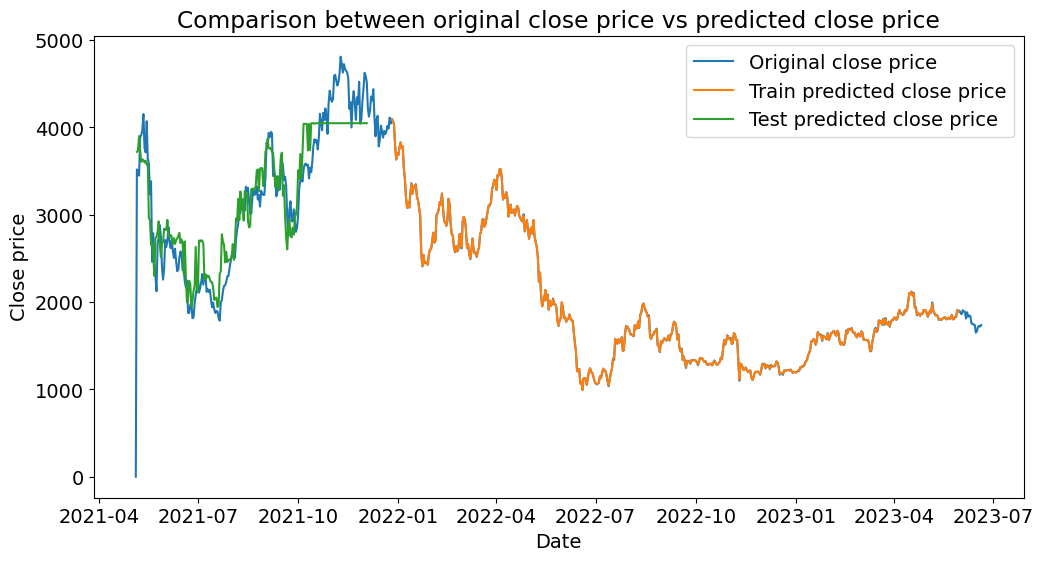

In [121]:

look_back=time_step
trainPredictPlot = np.empty_like(closedf)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)

# shift test predictions for plotting
testPredictPlot = np.empty_like(closedf)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(closedf)-1, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)

names = cycle(['Original close price','Train predicted close price','Test predicted close price'])

plotdf = pd.DataFrame({'date': close_stock['date'],
                       'original_close': close_stock['close'],
                      'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})



fig, ax = plt.subplots(figsize=(12, 6))

sns.lineplot(data=plotdf, x='date', y='original_close', ax=ax, label='Original close price')
sns.lineplot(data=plotdf, x='date', y='train_predicted_close', ax=ax, label='Train predicted close price')
sns.lineplot(data=plotdf, x='date', y='test_predicted_close', ax=ax, label='Test predicted close price')

ax.set_xlabel('Date')
ax.set_ylabel('Close price')
ax.set_title('Comparison between original close price vs predicted close price')
ax.grid(False)

plt.legend()
plt.show()


In [116]:
x_input=test_data[len(test_data)-time_step:].reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=time_step
i=0
pred_days = 10
while(i<pred_days):
    
    if(len(temp_input)>time_step):
        
        x_input=np.array(temp_input[1:])
        #print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        
        yhat = my_model.predict(x_input)
        #print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat.tolist())
        temp_input=temp_input[1:]
       
        lst_output.extend(yhat.tolist())
        i=i+1
        
    else:
        yhat = my_model.predict(x_input)
        
        temp_input.extend(yhat.tolist())
        lst_output.extend(yhat.tolist())
        
        i=i+1
        
print("Output of predicted next days: ", len(lst_output))

Output of predicted next days:  10


In [117]:
last_days=np.arange(1,time_step+1)
day_pred=np.arange(time_step+1,time_step+pred_days+1)
print(last_days)
print(day_pred)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
[22 23 24 25 26 27 28 29 30 31]


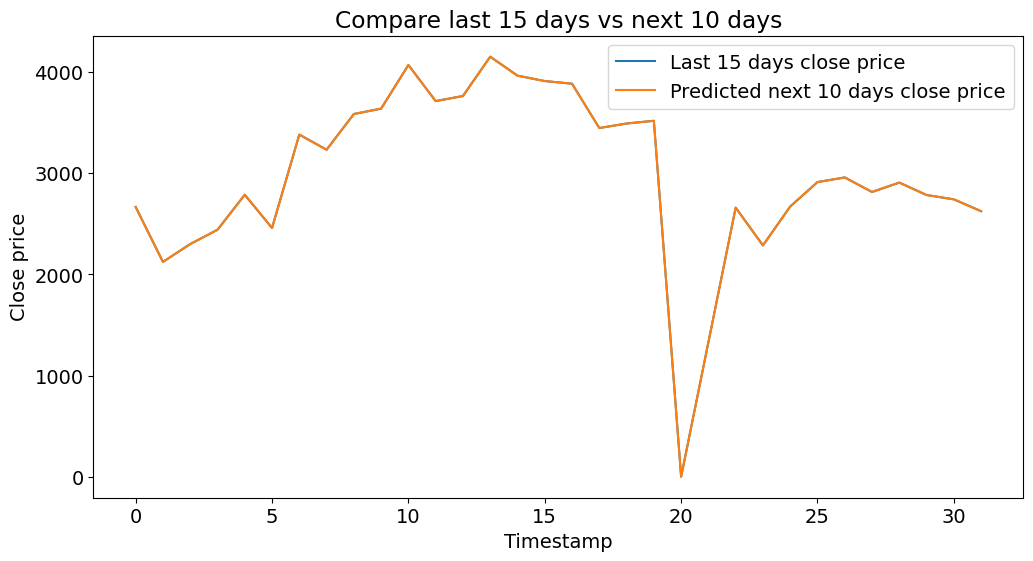

In [120]:
temp_mat = np.empty((len(last_days)+pred_days+1,1))
temp_mat[:] = np.nan
temp_mat = temp_mat.reshape(1,-1).tolist()[0]

last_original_days_value = temp_mat
next_predicted_days_value = temp_mat

last_original_days_value[0:time_step+1] = scaler.inverse_transform(closedf[len(closedf)-time_step:]).reshape(1,-1).tolist()[0]
next_predicted_days_value[time_step+1:] = scaler.inverse_transform(np.array(lst_output).reshape(-1,1)).reshape(1,-1).tolist()[0]

new_pred_plot = pd.DataFrame({
    'last_original_days_value':last_original_days_value,
    'next_predicted_days_value':next_predicted_days_value
})


fig, ax = plt.subplots(figsize=(12, 6))

sns.lineplot(data=new_pred_plot, x=new_pred_plot.index, y='last_original_days_value', ax=ax, label='Last 15 days close price')
sns.lineplot(data=new_pred_plot, x=new_pred_plot.index, y='next_predicted_days_value', ax=ax, label='Predicted next 10 days close price')

ax.set_xlabel('Timestamp')
ax.set_ylabel('Close price')
ax.set_title('Compare last 15 days vs next 10 days')
ax.grid(False)

plt.legend()
plt.show()


# LSTM

# ARIMA

# Prophet